In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_log_error
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = "drive/MyDrive/BANA 780 Assignments/A2/"
membersDF = pd.read_csv(path+'Members.csv') # loading Members data in a DF
membersDF

,MemberID,AgeAtFirstClaim,Sex
0,14723353,70-79,M
1,75706636,70-79,M
2,17320609,70-79,M
3,69690888,40-49,M
4,33004608,0-9,M
...,...,...,...
112995,99711514,40-49,F
112996,31690877,50-59,F
112997,9519985,30-39,F
112998,92806272,50-59,F


In [ ]:
membersDF.dtypes  # checking data types

MemberID            int64
AgeAtFirstClaim    object
Sex                object
dtype: object

In [ ]:
def checkNull(df):   # function to get null count and percent of null values for each column
    num_null = df.isnull().sum(axis=0)
    num_null = num_null[num_null > 0]
    percent_null = (df.isnull().sum(axis=0) / df.shape[0]) * 100
    percent_null = percent_null[percent_null > 0]
    nullDF = pd.concat([num_null,percent_null],axis=1)
    nullDF.columns = ['Count of Null values','Percent of Null values(%)']
    print(nullDF)

In [ ]:
checkNull(membersDF)  # printing count and percent of null values

                 Count of Null values  Percent of Null values(%)
AgeAtFirstClaim                  5753                   5.091150
Sex                             17552                  15.532743


Text(0.5, 0, 'AgeAtFirstClaim')

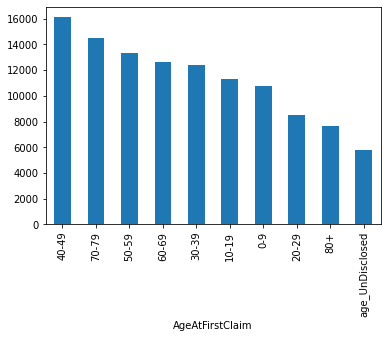

In [ ]:
membersDF['AgeAtFirstClaim'].fillna('age_UnDisclosed', inplace=True)  # replacing null values of age as  "age_UnDisclosed"
membersDF['AgeAtFirstClaim'].value_counts().plot(kind='bar') # Bar plot for age values
plt.xlabel("AgeAtFirstClaim")

In [ ]:
membersDFUpdated = pd.DataFrame()   # creating a new DF to store clean values of Members table
membersDFUpdated['MemberID']=membersDF['MemberID']

In [ ]:
# Categorizing age according to age groups

membersDFUpdated['Young'] = np.where((membersDF['AgeAtFirstClaim']=='0-9') | (membersDF['AgeAtFirstClaim']=='10-19'), 1, 0)
membersDFUpdated['Young Adults'] = np.where((membersDF['AgeAtFirstClaim']=='20-29') | (membersDF['AgeAtFirstClaim']=='30-39'), 1, 0)
membersDFUpdated['Middle Aged'] = np.where((membersDF['AgeAtFirstClaim']=='40-49') | (membersDF['AgeAtFirstClaim']=='50-59'), 1, 0)
membersDFUpdated['Senior Citizen'] = np.where((membersDF['AgeAtFirstClaim']=='60-69') | (membersDF['AgeAtFirstClaim']=='70-79'), 1, 0)
membersDFUpdated['Old'] = np.where((membersDF['AgeAtFirstClaim']=='80+'), 1, 0)
membersDFUpdated['age_UnDisclosed'] = np.where(membersDF['AgeAtFirstClaim']=='age_UnDisclosed', 1, 0)

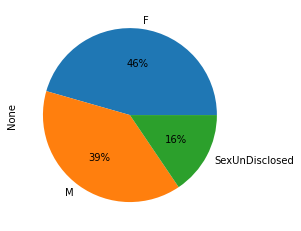

In [ ]:
membersDF['Sex'].fillna('SexUnDisclosed', inplace=True)  # setting "SexUnDisclosed" for null values in Sex column
membersDF.groupby(['Sex']).size().plot.pie(autopct='%1.0f%%') # plotting pie chart for sex column

In [ ]:
# creating new columns for each sex and setting binary value

membersDFUpdated['isMALE'] = np.where(membersDF['Sex']=='M', 1, 0)
membersDFUpdated['isFEMALE'] = np.where(membersDF['Sex']=='F', 1, 0)
membersDFUpdated['SexUnDisclosed'] = np.where(membersDF['Sex']=='SexUnDisclosed', 1, 0)

In [ ]:
checkNull(membersDF)

Empty DataFrame
Columns: [Count of Null values, Percent of Null values(%)]
Index: []


In [ ]:
membersDFUpdated.describe() # Members table transformed

,MemberID,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
count,1.130000e+05,113000.000000,113000.00000,113000.000000,113000.000000,113000.000000,113000.000000,113000.000000,113000.000000,113000.000000
mean,4.987601e+07,0.195664,0.18531,0.260531,0.240142,0.067442,0.050912,0.389080,0.455593,0.155327
std,2.890233e+07,0.396713,0.38855,0.438926,0.427171,0.250788,0.219818,0.487544,0.498026,0.362218
min,4.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473595e+07,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.988244e+07,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.500351e+07,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9.999882e+07,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
membersDFUpdated.head()

,MemberID,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
0,14723353,0,0,0,1,0,0,1,0,0
1,75706636,0,0,0,1,0,0,1,0,0
2,17320609,0,0,0,1,0,0,1,0,0
3,69690888,0,0,1,0,0,0,1,0,0
4,33004608,1,0,0,0,0,0,1,0,0


In [ ]:
ClaimsDF = pd.read_csv(path+'Claims.csv') # Loading Claims table in a DF
ClaimsDF

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2,2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
3,73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
4,11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668985,14932948,6641119.0,693028.0,22193.0,Y2,Obstetrics and Gynecology,Inpatient Hospital,58,NaN,0- 1 month,GYNEC1,0,EM,0
2668986,31248189,6932712.0,223304.0,70748.0,Y3,Internal,Inpatient Hospital,23,NaN,0- 1 month,GIBLEED,1-2,EM,0
2668987,43767339,1483429.0,35565.0,5278.0,Y3,Diagnostic Imaging,Office,122,NaN,4- 5 months,ODaBNCA,0,SIS,0
2668988,96393713,7094351.0,347045.0,93075.0,Y3,Internal,Office,151,NaN,1- 2 months,METAB3,1-2,EM,0


In [ ]:
ClaimsDF.dtypes # Checking data types in Claims table

MemberID                   int64
ProviderID               float64
Vendor                   float64
PCP                      float64
Year                      object
Specialty                 object
PlaceSvc                  object
PayDelay                  object
LengthOfStay              object
DSFS                      object
PrimaryConditionGroup     object
CharlsonIndex             object
ProcedureGroup            object
SupLOS                     int64
dtype: object

In [ ]:
checkNull(ClaimsDF) # checking for null values

                       Count of Null values  Percent of Null values(%)
ProviderID                            16264                   0.609369
Vendor                                24856                   0.931289
PCP                                    7492                   0.280705
Specialty                              8405                   0.314913
PlaceSvc                               7632                   0.285951
LengthOfStay                        2597392                  97.317412
DSFS                                  52770                   1.977152
PrimaryConditionGroup                 11410                   0.427503
ProcedureGroup                         3675                   0.137693


In [ ]:
# Function to remove '+' from column values
def remove_plus(str):
    str = str.replace("+","")
    return int(str)

In [ ]:
# Removing + sign from PayDelay column and converting to int
ClaimsDF["PayDelay"] = ClaimsDF["PayDelay"].apply(remove_plus)
ClaimsDF['PayDelay'] = ClaimsDF['PayDelay'].astype(int)

In [ ]:
dsfs = ClaimsDF['DSFS'].copy()     # storing values of DSFS column in a new series
dsfs.fillna('DSFS_missing', inplace=True) # filling null values with "DSFS_missing" to display on plot

Text(0.5, 0, 'DSFS')

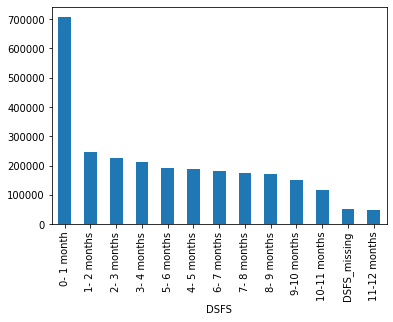

In [ ]:
dsfs.value_counts().plot(kind='bar') # plotting DSFS values
plt.xlabel("DSFS")

In [ ]:
ClaimsDF.DSFS = np.where(~ClaimsDF['DSFS'].isnull(),ClaimsDF['DSFS'].str[3],ClaimsDF['DSFS']) # storing ceiling value of DSFS month in int format. EX: 0- 1 months will be stored as 1
ClaimsDF['DSFS'].fillna(0, inplace=True) # replacing null values with 0
ClaimsDF['DSFS'] = ClaimsDF['DSFS'].astype(int) # converting DSFS column to int
ClaimsDF.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,9,NEUMENT,0,MED,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,8,NEUMENT,1-2,EM,0
2,2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,1,METAB3,0,EM,0
3,73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,6,METAB3,1-2,SCS,0
4,11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,5,FXDISLC,1-2,EM,0


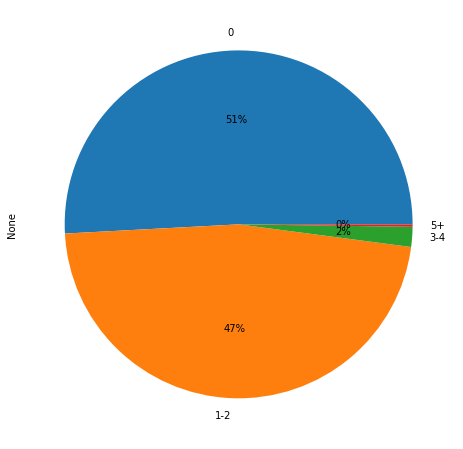

In [ ]:
ClaimsDF.groupby(['CharlsonIndex']).size().plot.pie(autopct='%1.0f%%' ,figsize=(8, 8)) # Plotting pie chart of CharlsonIndex column

In [ ]:
# storing ceiling value of CharlsonIndex in int format
ClaimsDF.loc[ClaimsDF['CharlsonIndex']=='0','CharlsonIndex'] = 0
ClaimsDF.loc[ClaimsDF['CharlsonIndex']=='1-2','CharlsonIndex'] = 2
ClaimsDF.loc[ClaimsDF['CharlsonIndex']=='3-4','CharlsonIndex'] = 4
ClaimsDF.loc[ClaimsDF['CharlsonIndex']=='5+','CharlsonIndex'] = 5
ClaimsDF['CharlsonIndex'] = ClaimsDF['CharlsonIndex'].astype(int)
ClaimsDF.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,9,NEUMENT,0,MED,0
1,97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,8,NEUMENT,2,EM,0
2,2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,1,METAB3,0,EM,0
3,73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,6,METAB3,2,SCS,0
4,11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,5,FXDISLC,2,EM,0


Text(0.5, 0, 'LengthOfStay')

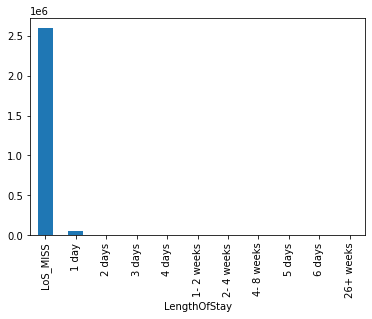

In [ ]:
ClaimsDF['LengthOfStay'].fillna('LoS_MISS', inplace=True) # Storing null values of LengthOfStay as LoS_MISS
ClaimsDF['LengthOfStay'].value_counts().plot(kind='bar') # plotting bar chart for LengthOfStay
plt.xlabel("LengthOfStay")

In [ ]:
# Converting LengthOfStay as int values in days. For weeks, ceiling value is multiplied by 7. For example: 1-2 weeks is stored as 2*7 = 14. Missing values replaced with 0.

ClaimsDF.loc[ClaimsDF['LengthOfStay']=='1 day','LengthOfStay'] = 1
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='2 days','LengthOfStay'] = 2
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='3 days','LengthOfStay'] = 3
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='4 days','LengthOfStay'] = 4
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='5 days','LengthOfStay'] = 5
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='6 days','LengthOfStay'] = 6
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='1- 2 weeks','LengthOfStay'] = 14
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='2- 4 weeks','LengthOfStay'] = 28
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='4- 8 weeks','LengthOfStay'] = 56
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='26+ weeks','LengthOfStay'] = 182
ClaimsDF.loc[ClaimsDF['LengthOfStay']=='LoS_MISS','LengthOfStay'] = 0

ClaimsDF['LengthOfStay'] = ClaimsDF['LengthOfStay'].astype(int)

In [ ]:
ClaimsDF.groupby('PlaceSvc')['LengthOfStay'].mean()

PlaceSvc
Ambulance              0.425531
Home                   3.662893
Independent Lab        0.000000
Inpatient Hospital     0.361348
Office                 0.000006
Other                  3.965128
Outpatient Hospital    0.232671
Urgent Care            0.157712
Name: LengthOfStay, dtype: float64

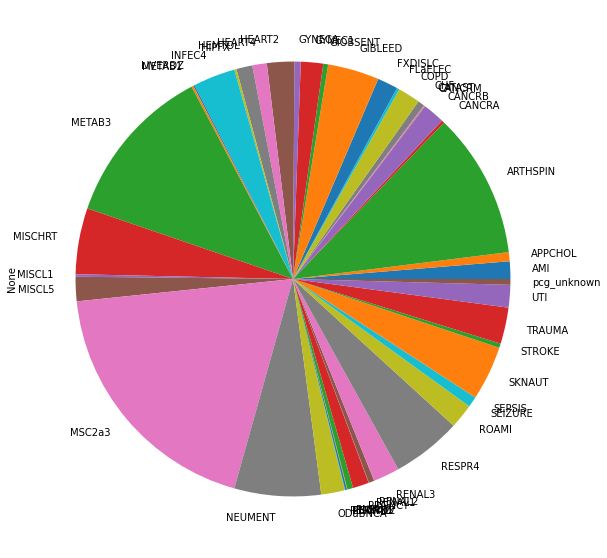

In [ ]:
ClaimsDF['PrimaryConditionGroup'].fillna('pcg_unknown', inplace=True) # Filling null values in PrimaryConditionGroup with pcg_unknown

plt.figure(figsize=(11, 10))
ClaimsDF.groupby(['PrimaryConditionGroup']).size().plot.pie() 

In [ ]:
df_pcg = pd.crosstab([ClaimsDF.MemberID, ClaimsDF.Year],ClaimsDF.PrimaryConditionGroup).reset_index() # converting in wide format. Each value in PrimaryConditionGroup column changed to a column and count of instances stored as column values.
df_pcg.columns.name = 'Index'
df_pcg

Index,MemberID,Year,AMI,APPCHOL,ARTHSPIN,CANCRA,CANCRB,CANCRM,CATAST,CHF,COPD,FLaELEC,FXDISLC,GIBLEED,GIOBSENT,GYNEC1,GYNECA,HEART2,HEART4,HEMTOL,HIPFX,INFEC4,LIVERDZ,METAB1,METAB3,MISCHRT,MISCL1,MISCL5,MSC2a3,NEUMENT,ODaBNCA,PERINTL,PERVALV,PNCRDZ,PNEUM,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown
0,4,Y2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,210,Y1,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,210,Y2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
3,210,Y3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
4,3197,Y1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218411,99997485,Y3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
218412,99997895,Y1,0,0,5,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
218413,99998627,Y1,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


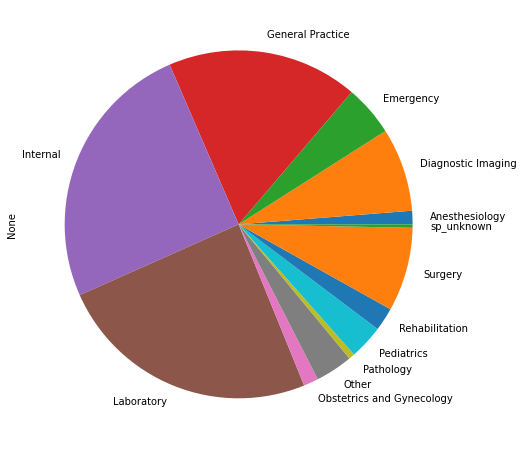

In [ ]:
ClaimsDF['Specialty'].fillna('sp_unknown', inplace=True) # Filling null values in Specialty with sp_unknown
plt.figure(figsize=(9, 8))
ClaimsDF.groupby(['Specialty']).size().plot.pie()

In [ ]:
df_sp = pd.crosstab([ClaimsDF.MemberID, ClaimsDF.Year],ClaimsDF.Specialty).reset_index() # converting in wide format. Each value in Specialty column changed to a column and count of instances stored as column values.
df_sp.columns.name = 'Index'
df_sp

Index,MemberID,Year,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,Obstetrics and Gynecology,Other,Pathology,Pediatrics,Rehabilitation,Surgery,sp_unknown
0,4,Y2,0,0,0,0,0,0,0,0,0,1,0,0,0
1,210,Y1,0,0,2,0,4,2,0,0,0,0,0,0,0
2,210,Y2,0,0,0,0,1,1,0,4,0,0,0,0,0
3,210,Y3,0,0,0,0,0,1,0,3,0,0,0,0,0
4,3197,Y1,0,0,2,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,0,0,0,1,0,0,0,0,0,0,0,0,0
218411,99997485,Y3,0,0,0,2,0,0,0,0,0,0,0,0,0
218412,99997895,Y1,0,1,0,0,4,7,0,0,0,0,0,2,0
218413,99998627,Y1,1,1,0,0,4,2,0,2,0,0,0,0,0


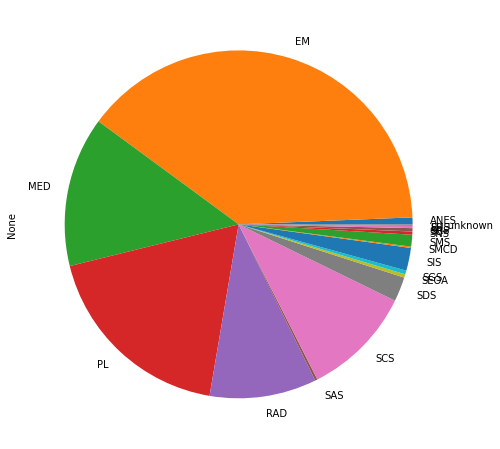

In [ ]:
ClaimsDF['ProcedureGroup'].fillna('pg_unknown', inplace=True) # Filling null values in ProcedureGroup with pg_unknown
plt.figure(figsize=(9, 8))
ClaimsDF.groupby(['ProcedureGroup']).size().plot.pie()

In [ ]:
df_pg = pd.crosstab([ClaimsDF.MemberID, ClaimsDF.Year],ClaimsDF.ProcedureGroup).reset_index() # converting in wide format. Each value in ProcedureGroup column changed to a column and count of instances stored as column values.
df_pg.columns.name = 'Index'
df_pg

Index,MemberID,Year,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown
0,4,Y2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,210,Y1,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,210,Y2,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,210,Y3,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3197,Y1,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218411,99997485,Y3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218412,99997895,Y1,0,6,0,4,1,0,3,0,0,0,0,0,0,0,0,0,0,0
218413,99998627,Y1,1,2,1,1,1,0,2,0,0,0,0,0,2,0,0,0,0,0


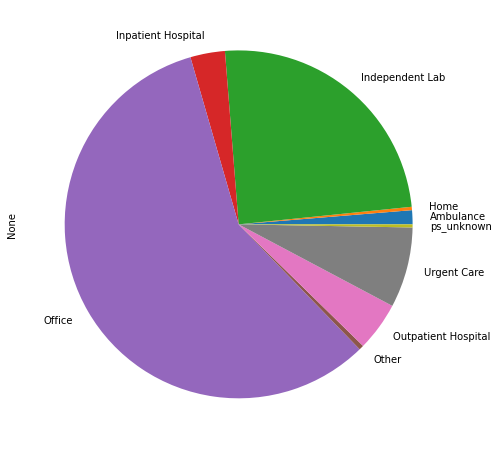

In [ ]:
ClaimsDF['PlaceSvc'].fillna('ps_unknown', inplace=True) # Filling null values in PlaceSvc with pg_unknown
plt.figure(figsize=(9, 8))
ClaimsDF.groupby(['PlaceSvc']).size().plot.pie()

In [ ]:
df_ps =pd.crosstab([ClaimsDF.MemberID, ClaimsDF.Year],ClaimsDF.PlaceSvc).reset_index() # converting in wide format. Each value in PlaceSvc column changed to a column and count of instances stored as column values.
df_ps.columns.name = 'Index'
df_ps

Index,MemberID,Year,Ambulance,Home,Independent Lab,Inpatient Hospital,Office,Other,Outpatient Hospital,Urgent Care,ps_unknown
0,4,Y2,0,0,0,0,1,0,0,0,0
1,210,Y1,0,0,2,0,4,0,0,2,0
2,210,Y2,0,0,1,0,5,0,0,0,0
3,210,Y3,0,0,1,0,3,0,0,0,0
4,3197,Y1,0,0,0,0,3,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,0,0,0,0,1,0,0,0,0
218411,99997485,Y3,0,0,0,0,2,0,0,0,0
218412,99997895,Y1,0,0,7,0,7,0,0,0,0
218413,99998627,Y1,0,0,2,0,3,0,5,0,0


In [ ]:
# Creating a DataFrame df_agg to store aggregated values like unique count, sum, mean, min, max

df_agg=ClaimsDF.groupby(['MemberID','Year']).agg({
    'ProviderID': 'nunique',
    'Vendor': 'nunique',
    'PCP': 'nunique',
    'PlaceSvc': 'nunique',
    'Specialty': 'nunique',
    'PrimaryConditionGroup': 'nunique',
    'ProcedureGroup': 'nunique',
    'PayDelay': ['sum','max','min'],
    'LengthOfStay': ['max','min','mean','sum'], 
    'DSFS': ['max','min','mean','sum'], 
    'CharlsonIndex': ['max','min','mean','sum'] 
}).reset_index()


# renaming columns for better understanding
df_agg.columns = ['MemberID', 'Year', 'no_Providers', 'no_Vendors','no_PCPs',
                   'no_PlaceSvcs', 'no_Specialities','no_PrimaryConditionGroups','no_ProcedureGroups',
                     'PayDelay_sum','PayDelay_max','PayDelay_min',
                     'LoS_max','LoS_min','LoS_mean','LoS_sum',
                     'DSFS_max','DSFS_min','DSFS_mean','DSFS_sum',
                     'CharlsonIndex_max','CharlsonIndex_min','CharlsonIndex_mean','CharlsonIndex_sum']
df_agg

,MemberID,Year,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum
0,4,Y2,1,1,1,1,1,1,1,43,43,43,0,0,0.000,0,1,1,1.000000,1,0,0,0.0,0
1,210,Y1,4,4,2,3,3,4,5,720,162,22,2,0,0.250,2,7,0,2.250000,18,0,0,0.0,0
2,210,Y2,3,3,1,2,3,2,3,308,128,31,0,0,0.000,0,7,0,2.833333,17,0,0,0.0,0
3,210,Y3,2,2,1,2,2,2,2,143,44,23,0,0,0.000,0,7,1,3.750000,15,0,0,0.0,0
4,3197,Y1,3,3,1,2,2,2,2,492,162,36,0,0,0.000,0,6,1,2.200000,11,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,1,1,1,1,1,1,1,130,130,130,0,0,0.000,0,1,1,1.000000,1,0,0,0.0,0
218411,99997485,Y3,1,1,1,1,1,1,2,46,46,0,0,0,0.000,0,1,1,1.000000,2,0,0,0.0,0
218412,99997895,Y1,5,4,1,2,4,6,4,539,99,12,0,0,0.000,0,9,0,3.714286,52,0,0,0.0,0
218413,99998627,Y1,7,7,1,3,5,3,7,526,98,29,1,0,0.200,2,1,1,1.000000,10,2,0,0.8,8


In [ ]:
df_merged = pd.merge(df_agg, df_sp, on=['MemberID','Year'], how='outer').sort_values(by=['MemberID','Year']) # Merging df_agg and df_sp on MemberID and Year using outer join


In [ ]:
df_merged = pd.merge(df_merged, df_ps, on=['MemberID','Year'], how='outer').sort_values(by=['MemberID','Year']) # Merging df_merged and df_ps on MemberID and Year using outer join

In [ ]:
df_merged = pd.merge(df_merged, df_pcg, on=['MemberID','Year'], how='outer').sort_values(by=['MemberID','Year']) # Merging df_merged and df_pcg on MemberID and Year using outer join

In [ ]:
df_merged = pd.merge(df_merged, df_pg, on=['MemberID','Year'], how='outer').sort_values(by=['MemberID','Year']) # Merging df_merged and df_pg on MemberID and Year using outer join

In [ ]:
df_claims_merged = df_merged.rename(columns={'Other_x': 'Other_sp', 'Other_y': 'Other_ps'}) # renaming columns for better understanding


In [ ]:
df_claims_merged # Claims table transformed

,MemberID,Year,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,Obstetrics and Gynecology,Other_sp,Pathology,Pediatrics,Rehabilitation,Surgery,sp_unknown,Ambulance,Home,Independent Lab,...,MISCL1,MISCL5,MSC2a3,NEUMENT,ODaBNCA,PERINTL,PERVALV,PNCRDZ,PNEUM,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown
0,4,Y2,1,1,1,1,1,1,1,43,43,43,0,0,0.000,0,1,1,1.000000,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,210,Y1,4,4,2,3,3,4,5,720,162,22,2,0,0.250,2,7,0,2.250000,18,0,0,0.0,0,0,0,2,0,4,2,0,0,0,0,0,0,0,0,0,2,...,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,210,Y2,3,3,1,2,3,2,3,308,128,31,0,0,0.000,0,7,0,2.833333,17,0,0,0.0,0,0,0,0,0,1,1,0,4,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,210,Y3,2,2,1,2,2,2,2,143,44,23,0,0,0.000,0,7,1,3.750000,15,0,0,0.0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3197,Y1,3,3,1,2,2,2,2,492,162,36,0,0,0.000,0,6,1,2.200000,11,0,0,0.0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99997485,Y1,1,1,1,1,1,1,1,130,130,130,0,0,0.000,0,1,1,1.000000,1,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218411,99997485,Y3,1,1,1,1,1,1,2,46,46,0,0,0,0.000,0,1,1,1.000000,2,0,0,0.0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218412,99997895,Y1,5,4,1,2,4,6,4,539,99,12,0,0,0.000,0,9,0,3.714286,52,0,0,0.0,0,0,1,0,0,4,7,0,0,0,0,0,2,0,0,0,7,...,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,0,4,1,0,3,0,0,0,0,0,0,0,0,0,0,0
218413,99998627,Y1,7,7,1,3,5,3,7,526,98,29,1,0,0.200,2,1,1,1.000000,10,2,0,0.8,8,1,1,0,0,4,2,0,2,0,0,0,0,0,0,0,2,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,0,2,0,0,0,0,0,2,0,0,0,0,0


In [ ]:
LabDF = pd.read_csv(path+'LabCount.csv') # loading LabCount table in a DF
LabDF

,MemberID,Year,DSFS,LabCount
0,69258001,Y3,2- 3 months,1
1,10143167,Y1,0- 1 month,2
2,1054357,Y1,0- 1 month,6
3,56583841,Y3,6- 7 months,4
4,70967047,Y2,0- 1 month,2
...,...,...,...,...
361479,43366611,Y1,5- 6 months,2
361480,72106973,Y3,3- 4 months,10+
361481,97884558,Y1,0- 1 month,4
361482,38125799,Y3,6- 7 months,3


In [ ]:
checkNull(LabDF) # checking for null values

Empty DataFrame
Columns: [Count of Null values, Percent of Null values(%)]
Index: []


In [ ]:
LabDF.dtypes # checking data types

MemberID     int64
Year        object
DSFS        object
LabCount    object
dtype: object

Text(0.5, 0, 'LabCount')

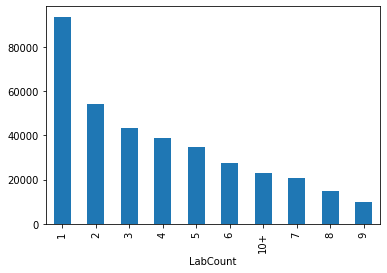

In [ ]:
LabDF['LabCount'].value_counts().plot(kind='bar') # plotting bar chart for LabCount
plt.xlabel("LabCount")

In [ ]:
LabDF["LabCount"] = LabDF["LabCount"].apply(remove_plus) # Removing '+' and converting to int

In [ ]:
LabDF.dtypes

MemberID     int64
Year        object
DSFS        object
LabCount     int64
dtype: object

In [ ]:
LabDF_grouped = LabDF.groupby(['MemberID','Year']).agg({'LabCount': ['sum','count','max','min','mean']}).reset_index() # Finding sum, count, max, min and mean of LabCount and stroing in columns
LabDF_grouped.head()

MemberID Year LabCount                   
                     sum count max min mean
0      210   Y1        2     1   2   2  2.0
1      210   Y2        1     1   1   1  1.0
2      210   Y3        1     1   1   1  1.0
3     3197   Y2        2     1   2   2  2.0
4     3713   Y2        9     2   8   1  4.5

In [ ]:
checkNull(LabDF)

Empty DataFrame
Columns: [Count of Null values, Percent of Null values(%)]
Index: []


In [ ]:
LabDF_grouped.columns = ['MemberID', 'Year', 'LabCount_sum', 'LabCount_count','LabCount_max','LabCount_min','LabCount_mean'] # renaming columns
LabDF_grouped.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean
0,210,Y1,2,1,2,2,2.0
1,210,Y2,1,1,1,1,1.0
2,210,Y3,1,1,1,1,1.0
3,3197,Y2,2,1,2,2,2.0
4,3713,Y2,9,2,8,1,4.5


In [ ]:
drugsDF = pd.read_csv(path+'DrugCount.csv') # loading DrugCount table in a DF
drugsDF

,MemberID,Year,DSFS,DrugCount
0,48925661,Y2,9-10 months,7+
1,90764620,Y3,8- 9 months,3
2,61221204,Y1,2- 3 months,1
3,63628544,Y3,1- 2 months,1
4,46949606,Y2,10-11 months,3
...,...,...,...,...
818236,23642577,Y1,5- 6 months,1
818237,99212686,Y1,1- 2 months,2
818238,3846152,Y3,10-11 months,1
818239,56710672,Y1,1- 2 months,3


In [ ]:
checkNull(drugsDF) # checking for null values

Empty DataFrame
Columns: [Count of Null values, Percent of Null values(%)]
Index: []


Text(0.5, 0, 'DrugCount')

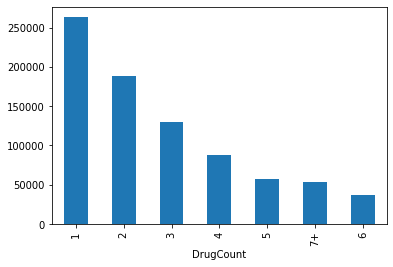

In [ ]:
drugsDF['DrugCount'].value_counts().plot(kind='bar') # plotting bar chart for LabCount
plt.xlabel("DrugCount")

In [ ]:
drugsDF["DrugCount"] = drugsDF["DrugCount"].apply(remove_plus) # Removing '+' and converting to int

In [ ]:
drugsDF.dtypes

MemberID      int64
Year         object
DSFS         object
DrugCount     int64
dtype: object

In [ ]:
drugsDF_grouped = drugsDF.groupby(['MemberID','Year']).agg({'DrugCount': ['sum','count','max','min','mean']}).reset_index() # Finding sum, count, max, min and mean of DrugCount and stroing in columns
drugsDF_grouped.head()

MemberID Year DrugCount                        
                      sum count max min      mean
0      210   Y1         5     3   2   1  1.666667
1      210   Y3         5     4   2   1  1.250000
2     3197   Y1         5     4   2   1  1.250000
3     3197   Y2         3     2   2   1  1.500000
4     3197   Y3         6     5   2   1  1.200000

In [ ]:
checkNull(drugsDF)

Empty DataFrame
Columns: [Count of Null values, Percent of Null values(%)]
Index: []


In [ ]:
drugsDF_grouped.columns = ['MemberID', 'Year', 'DrugCount_sum', 'DrugCount_count','DrugCount_max','DrugCount_min','DrugCount_mean'] # renaming columns
drugsDF_grouped.head()

,MemberID,Year,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean
0,210,Y1,5,3,2,1,1.666667
1,210,Y3,5,4,2,1,1.250000
2,3197,Y1,5,4,2,1,1.250000
3,3197,Y2,3,2,2,1,1.500000
4,3197,Y3,6,5,2,1,1.200000


In [ ]:
df_lab_drug_merged = pd.merge(LabDF_grouped, drugsDF_grouped, on=['MemberID', 'Year'], how='outer') # merging DrugCount and LabCount datasets
df_lab_drug_merged

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667
1,210,Y2,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,210,Y3,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000
3,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000
4,3713,Y2,9.0,2.0,8.0,1.0,4.5,17.0,4.0,6.0,1.0,4.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
186797,99985795,Y3,NaN,NaN,NaN,NaN,NaN,22.0,10.0,4.0,1.0,2.200000
186798,99985996,Y2,NaN,NaN,NaN,NaN,NaN,18.0,6.0,3.0,3.0,3.000000
186799,99985996,Y3,NaN,NaN,NaN,NaN,NaN,35.0,12.0,4.0,1.0,2.916667
186800,99987030,Y2,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,2.000000


In [ ]:
df_lab_drug_claim_merged = pd.merge(df_lab_drug_merged, df_claims_merged, on=['MemberID', 'Year'], how='outer') # merging Claims and df_lab_drug_merged datasets
df_lab_drug_claim_merged.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,MISCL1,MISCL5,MSC2a3,NEUMENT,ODaBNCA,PERINTL,PERVALV,PNCRDZ,PNEUM,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.25,2,7,0,2.250000,18,0,0,0.0,0,0,0,2,0,4,2,...,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,210,Y2,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3,3,1,2,3,2,3,308,128,31,0,0,0.00,0,7,0,2.833333,17,0,0,0.0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,210,Y3,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000,2,2,1,2,2,2,2,143,44,23,0,0,0.00,0,7,1,3.750000,15,0,0,0.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000,4,3,1,2,4,2,4,148,34,26,0,0,0.00,0,2,1,1.800000,9,0,0,0.0,0,0,1,0,0,1,2,...,0,0,0,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3713,Y2,9.0,2.0,8.0,1.0,4.5,17.0,4.0,6.0,1.0,4.250000,5,5,2,2,3,5,3,562,118,23,0,0,0.00,0,9,1,4.700000,47,0,0,0.0,0,0,1,0,7,0,2,...,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,2,0,0,5,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_all_merged = pd.merge(df_lab_drug_claim_merged, membersDFUpdated, on='MemberID') # merging membersDFUpdated and df_lab_drug_claim_merged datasets
df_all_merged.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.25,2,7,0,2.250000,18,0,0,0.0,0,0,0,2,0,4,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,210,Y2,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3,3,1,2,3,2,3,308,128,31,0,0,0.00,0,7,0,2.833333,17,0,0,0.0,0,0,0,0,0,1,1,...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,210,Y3,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000,2,2,1,2,2,2,2,143,44,23,0,0,0.00,0,7,1,3.750000,15,0,0,0.0,0,0,0,0,0,0,1,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000,4,3,1,2,4,2,4,148,34,26,0,0,0.00,0,2,1,1.800000,9,0,0,0.0,0,0,1,0,0,1,2,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,3197,Y1,NaN,NaN,NaN,NaN,NaN,5.0,4.0,2.0,1.0,1.250000,3,3,1,2,2,2,2,492,162,36,0,0,0.00,0,6,1,2.200000,11,0,0,0.0,0,0,0,2,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
checkNull(df_all_merged) # checking null values

                 Count of Null values  Percent of Null values(%)
LabCount_sum                    63481                  29.064396
LabCount_count                  63481                  29.064396
LabCount_max                    63481                  29.064396
LabCount_min                    63481                  29.064396
LabCount_mean                   63481                  29.064396
DrugCount_sum                   76844                  35.182565
DrugCount_count                 76844                  35.182565
DrugCount_max                   76844                  35.182565
DrugCount_min                   76844                  35.182565
DrugCount_mean                  76844                  35.182565


In [ ]:
df_all_merged.fillna(0, inplace=True) # replacing null values with 0

In [ ]:
df_all_merged # Final dataset 

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.25,2,7,0,2.250000,18,0,0,0.0,0,0,0,2,0,4,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,210,Y2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,3,308,128,31,0,0,0.00,0,7,0,2.833333,17,0,0,0.0,0,0,0,0,0,1,1,...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,210,Y3,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000,2,2,1,2,2,2,2,143,44,23,0,0,0.00,0,7,1,3.750000,15,0,0,0.0,0,0,0,0,0,0,1,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000,4,3,1,2,4,2,4,148,34,26,0,0,0.00,0,2,1,1.800000,9,0,0,0.0,0,0,1,0,0,1,2,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,3197,Y1,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,1.0,1.250000,3,3,1,2,2,2,2,492,162,36,0,0,0.00,0,6,1,2.200000,11,0,0,0.0,0,0,0,2,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218410,99944120,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,1,51,29,22,0,0,0.00,0,7,1,4.000000,8,0,0,0.0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
218411,99954127,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,1,36,36,36,0,0,0.00,0,1,1,1.000000,1,2,2,2.0,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
218412,99979211,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,2,114,57,57,0,0,0.00,0,1,1,1.000000,2,0,0,0.0,0,0,0,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
218413,99979429,Y3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,2,1,1,2,2,1,78,51,27,0,0,0.00,0,1,1,1.000000,2,0,0,0.0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
df_hospitalY2 = pd.read_csv(path+'/DaysInHospital_Y2.csv') # loading DaysInHospital_Y2 data in a DF
df_hospitalY2.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,7.603800e+04,76038.000000,76038.000000
mean,4.994761e+07,0.052224,0.467095
std,2.890145e+07,0.222480,1.612194
min,2.100000e+02,0.000000,0.000000
25%,2.483719e+07,0.000000,0.000000
50%,4.990721e+07,0.000000,0.000000
75%,7.510112e+07,0.000000,0.000000
max,9.999863e+07,1.000000,15.000000


In [ ]:
df_hospitalY3  = pd.read_csv(path+'DaysInHospital_Y3.csv') # loading DaysInHospital_Y3 data in a DF
df_hospitalY3.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,7.143500e+04,71435.000000,71435.000000
mean,4.993986e+07,0.056611,0.437895
std,2.894077e+07,0.231099,1.531780
min,4.000000e+00,0.000000,0.000000
25%,2.477813e+07,0.000000,0.000000
50%,4.995379e+07,0.000000,0.000000
75%,7.521986e+07,0.000000,0.000000
max,9.999882e+07,1.000000,15.000000


In [ ]:
df_hospitalY4  = pd.read_csv(path+'Target.csv') # loading Target data in a DF
df_hospitalY4.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,7.094200e+04,70942.000000,0.0
mean,4.991530e+07,0.055933,NaN
std,2.893409e+07,0.229794,NaN
min,2.100000e+02,0.000000,NaN
25%,2.472547e+07,0.000000,NaN
50%,4.994500e+07,0.000000,NaN
75%,7.514558e+07,0.000000,NaN
max,9.999748e+07,1.000000,NaN


In [ ]:
data1 = df_all_merged[df_all_merged['Year']=='Y1'] # getting Y1 data from df_all_merged
data1.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.250000,2,7,0,2.250000,18,0,0,0.000000,0,0,0,2,0,4,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,3197,Y1,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,1.0,1.250000,3,3,1,2,2,2,2,492,162,36,0,0,0.000000,0,6,1,2.200000,11,0,0,0.000000,0,0,0,2,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,3889,Y1,10.0,1.0,10.0,10.0,10.0,30.0,10.0,5.0,2.0,3.000000,7,7,1,3,4,5,5,919,162,33,2,0,0.230769,3,2,1,1.076923,14,2,0,0.615385,8,0,1,4,0,4,4,...,0,0,0,0,0,0,4,0,0,2,0,0,0,0,5,0,4,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
14,11951,Y1,3.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,4,250,54,32,0,0,0.000000,0,5,1,4.333333,26,0,0,0.000000,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
19,14661,Y1,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.000000,2,2,1,2,2,2,2,153,115,38,0,0,0.000000,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
data2 = df_all_merged[df_all_merged['Year']=='Y2'] # getting Y2 data from df_all_merged
data2.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
1,210,Y2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,3,308,128,31,0,0,0.0,0,7,0,2.833333,17,0,0,0.0,0,0,0,0,0,1,1,...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000,4,3,1,2,4,2,4,148,34,26,0,0,0.0,0,2,1,1.800000,9,0,0,0.0,0,0,1,0,0,1,2,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6,3713,Y2,9.0,2.0,8.0,1.0,4.5,17.0,4.0,6.0,1.0,4.250000,5,5,2,2,3,5,3,562,118,23,0,0,0.0,0,9,1,4.700000,47,0,0,0.0,0,0,1,0,7,0,2,...,0,0,0,2,1,0,0,0,0,0,0,2,0,0,5,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,3741,Y2,11.0,5.0,5.0,1.0,2.2,35.0,11.0,5.0,3.0,3.181818,3,3,1,2,3,4,4,360,36,8,0,0,0.0,0,8,1,3.650000,73,2,0,0.2,4,0,0,0,0,7,11,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,8,1,6,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
11,5187,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,2,1,65,42,23,0,0,0.0,0,1,1,1.000000,2,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
data3 = df_all_merged[df_all_merged['Year']=='Y3']  # getting Y3 data from df_all_merged
data3.head()

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,PRGNCY,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed
2,210,Y3,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000,2,2,1,2,2,2,2,143,44,23,0,0,0.000000,0,7,1,3.750000,15,0,0,0.000000,0,0,0,0,0,0,1,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
5,3197,Y3,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,1.0,1.200000,3,1,1,1,2,3,2,379,119,21,0,0,0.000000,0,8,1,3.000000,33,2,2,2.000000,22,0,0,0,0,9,0,...,0,0,0,0,7,0,0,0,0,0,0,0,0,0,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
9,4048,Y3,16.0,2.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,1.000000,10,9,1,5,6,5,7,675,80,0,1,0,0.136364,3,3,1,1.954545,43,2,0,0.818182,18,0,1,2,0,7,4,...,0,0,0,10,1,0,0,0,0,0,0,1,0,0,7,2,5,2,0,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
10,5187,Y3,1.0,1.0,1.0,1.0,1.0,10.0,6.0,3.0,1.0,1.666667,4,3,1,2,4,4,4,563,100,16,0,0,0.000000,0,5,1,2.538462,33,2,0,0.307692,4,0,2,0,2,1,0,...,0,0,0,0,7,0,0,0,0,0,0,0,0,0,6,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
17,14033,Y3,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.000000,7,7,1,2,6,2,6,330,68,26,2,0,0.250000,2,1,1,1.000000,8,0,0,0.000000,0,1,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
data1 = pd.merge(data1, df_hospitalY2, on='MemberID') # merging Y1 data with days in hospital Y2

In [ ]:
data2 = pd.merge(data2, df_hospitalY3, on='MemberID') # merging Y2 data with days in hospital Y3

In [ ]:
data3 = pd.merge(data3, df_hospitalY4, on='MemberID') # merging Y3 data with days in hospital Y2 to be predicted

In [ ]:
data1

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed,ClaimsTruncated,DaysInHospital
0,210,Y1,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.250000,2,7,0,2.250000,18,0,0,0.000000,0,0,0,2,0,4,2,...,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,3197,Y1,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,1.0,1.250000,3,3,1,2,2,2,2,492,162,36,0,0,0.000000,0,6,1,2.200000,11,0,0,0.000000,0,0,0,2,0,0,0,...,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3889,Y1,10.0,1.0,10.0,10.0,10.0,30.0,10.0,5.0,2.0,3.000000,7,7,1,3,4,5,5,919,162,33,2,0,0.230769,3,2,1,1.076923,14,2,0,0.615385,8,0,1,4,0,4,4,...,0,0,0,0,4,0,0,2,0,0,0,0,5,0,4,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,11951,Y1,3.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,4,250,54,32,0,0,0.000000,0,5,1,4.333333,26,0,0,0.000000,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,14661,Y1,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.000000,2,2,1,2,2,2,2,153,115,38,0,0,0.000000,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76033,99805886,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,2,1,1,1,2,3,117,43,37,1,0,0.333333,1,1,1,1.000000,3,0,0,0.000000,0,0,0,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
76034,99811836,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,2,1,1,3,3,3,309,92,69,0,0,0.000000,0,1,1,1.000000,4,2,0,1.500000,6,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,7
76035,99822996,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,2,1,1,2,1,2,43,25,18,1,0,0.500000,1,1,1,1.000000,2,0,0,0.000000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
76036,99979211,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,2,114,57,57,0,0,0.000000,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,2,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
data2

,MemberID,Year,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,...,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed,ClaimsTruncated,DaysInHospital
0,210,Y2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,3,308,128,31,0,0,0.0,0,7,0,2.833333,17,0,0,0.000000,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,3197,Y2,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.500000,4,3,1,2,4,2,4,148,34,26,0,0,0.0,0,2,1,1.800000,9,0,0,0.000000,0,0,1,0,0,1,2,...,0,0,4,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3713,Y2,9.0,2.0,8.0,1.0,4.5,17.0,4.0,6.0,1.0,4.250000,5,5,2,2,3,5,3,562,118,23,0,0,0.0,0,9,1,4.700000,47,0,0,0.000000,0,0,1,0,7,0,2,...,0,2,1,0,0,0,0,0,0,2,0,0,5,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,3741,Y2,11.0,5.0,5.0,1.0,2.2,35.0,11.0,5.0,3.0,3.181818,3,3,1,2,3,4,4,360,36,8,0,0,0.0,0,8,1,3.650000,73,2,0,0.200000,4,0,0,0,0,7,11,...,0,0,0,0,0,0,1,0,0,0,0,0,8,1,6,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,5187,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,2,1,65,42,23,0,0,0.0,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71430,99886482,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,2,112,56,56,0,0,0.0,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
71431,99908549,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,1,21,21,21,0,0,0.0,0,1,1,1.000000,1,0,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
71432,99910963,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,1,2,3,2,918,120,11,0,0,0.0,0,9,0,3.906977,168,2,0,0.883721,38,0,0,0,35,8,0,...,0,0,35,0,0,0,0,0,0,0,0,0,10,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
71433,99944120,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,1,1,1,51,29,22,0,0,0.0,0,7,1,4.000000,8,0,0,0.000000,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
dataY1 = data1.copy()
dataY2 = data2.copy()

In [ ]:
data_combined = pd.concat([dataY1, dataY2], ignore_index=True) # merging Y1 and Y2 data by rows

In [ ]:
data_combined.drop("MemberID", axis = 1, inplace = True) # dropping MemberID column for regression
data_combined.drop("Year", axis = 1, inplace = True) # dropping Year column for regression

y = data_combined['DaysInHospital']  # Target variable
X = data_combined.drop("DaysInHospital", axis = 1) # all except DaysInHospital are predictor variables
X.head()

,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PCPs,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_max,LoS_min,LoS_mean,LoS_sum,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_min,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,Obstetrics and Gynecology,Other_sp,...,RENAL1,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SGS,SIS,SMCD,SMS,SNS,SO,SRS,SUS,pg_unknown,Young,Young Adults,Middle Aged,Senior Citizen,Old,age_UnDisclosed,isMALE,isFEMALE,SexUnDisclosed,ClaimsTruncated
0,2.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,1.0,1.666667,4,4,2,3,3,4,5,720,162,22,2,0,0.250000,2,7,0,2.250000,18,0,0,0.000000,0,0,0,2,0,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,1.0,1.250000,3,3,1,2,2,2,2,492,162,36,0,0,0.000000,0,6,1,2.200000,11,0,0,0.000000,0,0,0,2,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,10.0,1.0,10.0,10.0,10.0,30.0,10.0,5.0,2.0,3.000000,7,7,1,3,4,5,5,919,162,33,2,0,0.230769,3,2,1,1.076923,14,2,0,0.615385,8,0,1,4,0,4,4,0,0,...,0,0,0,0,0,4,0,0,2,0,0,0,0,5,0,4,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,3.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.000000,3,3,1,2,3,2,4,250,54,32,0,0,0.000000,0,5,1,4.333333,26,0,0,0.000000,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.000000,2,2,1,2,2,2,2,153,115,38,0,0,0.000000,0,1,1,1.000000,2,0,0,0.000000,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)  # setting test as 30% of data

In [ ]:
def evaluateModel(model, X_test, y_test):
    pred_y = model.predict(X_test) # predicted y values
    pred_y = pred_y.clip(min=0) # setting negative values as 0
    pred_y = pred_y.astype(int) # converting to int
    
    msle = mean_squared_log_error(y_test, pred_y)
    rmsle = np.sqrt(msle) # The root mean square logarithmic error
    
    print ("RMSLE: %.4f" % rmsle)
    
    r2 = model.score(X_test, y_test) # getting R2
    print ("R2 value: %.4f" % r2)

In [ ]:
# Model using all predictor variables

model1 = linear_model.LinearRegression()
model1.fit(X_train1, y_train1)
evaluateModel(model1, X_test1, y_test1)

RMSLE: 0.4909
R2 value: 0.0795


In [ ]:
rfe=RFE(estimator=DecisionTreeRegressor(),  step=1) # Using recursive feature elimination to select best features

In [ ]:
selector=rfe.fit(X_train1[0:50000],y_train1[0:50000]) # using 50000 rows from train data to find best features

In [ ]:
filter = selector.support_  # best columns returned
ranking = selector.ranking_ # column ranks

features = X_train1.columns # all columns from train dataset
print("Selected features:")
print(features[filter]) # filtered columns
len(features[filter]) # filtered columns length
features2 = features[filter]

Selected features:
Index(['LabCount_sum', 'LabCount_count', 'LabCount_max', 'LabCount_min',
       'LabCount_mean', 'DrugCount_sum', 'DrugCount_count', 'DrugCount_max',
       'DrugCount_min', 'DrugCount_mean', 'no_Providers', 'no_Vendors',
       'no_Specialities', 'no_PrimaryConditionGroups', 'no_ProcedureGroups',
       'PayDelay_sum', 'PayDelay_max', 'PayDelay_min', 'LoS_mean', 'DSFS_max',
       'DSFS_mean', 'DSFS_sum', 'CharlsonIndex_mean', 'CharlsonIndex_sum',
       'Diagnostic Imaging', 'Emergency', 'General Practice', 'Internal',
       'Laboratory', 'Surgery', 'sp_unknown', 'Independent Lab',
       'Inpatient Hospital', 'Office', 'Outpatient Hospital', 'Urgent Care',
       'ARTHSPIN', 'CANCRB', 'COPD', 'GIBLEED', 'HEART4', 'HEMTOL', 'INFEC4',
       'METAB3', 'MISCHRT', 'MISCL5', 'MSC2a3', 'NEUMENT', 'PRGNCY', 'RENAL3',
       'RESPR4', 'ROAMI', 'SEIZURE', 'SKNAUT', 'TRAUMA', 'UTI', 'EM', 'MED',
       'PL', 'RAD', 'SDS', 'SIS', 'SexUnDisclosed', 'ClaimsTruncated'],
      

In [ ]:
X2 = X[features2] # filtering only columns returned by RFE

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=42) # creating test and train sets

model2 = linear_model.LinearRegression() # creating a new model
model2.fit(X_train2, y_train2) # training model
evaluateModel(model2, X_test2, y_test2) # evaluating the new model

RMSLE: 0.4951
R2 value: 0.0706


In [ ]:
rfe=RFE(estimator=DecisionTreeRegressor(),step=1,n_features_to_select=100) # Using recursive feature elimination to select 100 best features

In [ ]:
selector=rfe.fit(X_train1[0:50000],y_train1[0:50000]) # using 50000 rows from train data to find best features

In [ ]:
filter = selector.support_ # best columns returned
ranking = selector.ranking_ # column ranks
 

features = X_train1.columns # all columns from train dataset
print("Selected features:")
print(features[filter]) # filtered columns
len(features[filter]) # filtered columns length
features3 = features[filter]

Selected features:
Index(['LabCount_sum', 'LabCount_count', 'LabCount_max', 'LabCount_min',
       'LabCount_mean', 'DrugCount_sum', 'DrugCount_count', 'DrugCount_max',
       'DrugCount_min', 'DrugCount_mean', 'no_Providers', 'no_Vendors',
       'no_PlaceSvcs', 'no_Specialities', 'no_PrimaryConditionGroups',
       'no_ProcedureGroups', 'PayDelay_sum', 'PayDelay_max', 'PayDelay_min',
       'LoS_mean', 'LoS_sum', 'DSFS_max', 'DSFS_mean', 'DSFS_sum',
       'CharlsonIndex_max', 'CharlsonIndex_mean', 'CharlsonIndex_sum',
       'Anesthesiology', 'Diagnostic Imaging', 'Emergency', 'General Practice',
       'Internal', 'Laboratory', 'Obstetrics and Gynecology', 'Other_sp',
       'Pathology', 'Pediatrics', 'Rehabilitation', 'Surgery', 'sp_unknown',
       'Home', 'Independent Lab', 'Inpatient Hospital', 'Office', 'Other_ps',
       'Outpatient Hospital', 'Urgent Care', 'AMI', 'APPCHOL', 'ARTHSPIN',
       'CANCRA', 'CANCRB', 'CHF', 'COPD', 'GIBLEED', 'GIOBSENT', 'GYNEC1',
       'GYNECA

In [ ]:
X3 = X[features3] # filtering only columns returned by RFE

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=42) # creating test and train sets

model3 = linear_model.LinearRegression() # creating a new model
model3.fit(X_train3, y_train3) # training model
evaluateModel(model3, X_test3, y_test3) # evaluating the new model

RMSLE: 0.4905
R2 value: 0.0795


In [ ]:
rfe=RFE(estimator=DecisionTreeRegressor(),step=1,n_features_to_select=90) # Using recursive feature elimination to select 90 best features

In [ ]:
selector=rfe.fit(X_train1[0:50000],y_train1[0:50000]) # using 50000 rows from train data to find best features

In [ ]:
filter = selector.support_ # best columns returned
ranking = selector.ranking_ # column ranks
 

features = X_train1.columns # all columns from train dataset
print("Selected features:")
print(features[filter]) # filtered columns
len(features[filter]) # filtered columns length
features4 = features[filter]

Selected features:
Index(['LabCount_sum', 'LabCount_count', 'LabCount_max', 'LabCount_min',
       'LabCount_mean', 'DrugCount_sum', 'DrugCount_count', 'DrugCount_max',
       'DrugCount_min', 'DrugCount_mean', 'no_Providers', 'no_Vendors',
       'no_PlaceSvcs', 'no_Specialities', 'no_PrimaryConditionGroups',
       'no_ProcedureGroups', 'PayDelay_sum', 'PayDelay_max', 'PayDelay_min',
       'LoS_mean', 'LoS_sum', 'DSFS_max', 'DSFS_mean', 'DSFS_sum',
       'CharlsonIndex_mean', 'CharlsonIndex_sum', 'Anesthesiology',
       'Diagnostic Imaging', 'Emergency', 'General Practice', 'Internal',
       'Laboratory', 'Obstetrics and Gynecology', 'Other_sp', 'Pathology',
       'Pediatrics', 'Surgery', 'sp_unknown', 'Independent Lab',
       'Inpatient Hospital', 'Office', 'Other_ps', 'Outpatient Hospital',
       'Urgent Care', 'AMI', 'APPCHOL', 'ARTHSPIN', 'CANCRA', 'CANCRB', 'CHF',
       'COPD', 'GIBLEED', 'GIOBSENT', 'GYNEC1', 'HEART2', 'HEART4', 'HEMTOL',
       'HIPFX', 'INFEC4', 'META

In [ ]:
X4 = X[features4] # filtering only columns returned by RFE

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.3, random_state=42) # creating test and train sets

model4 = linear_model.LinearRegression() # creating a new model
model4.fit(X_train4, y_train4) # training model
evaluateModel(model4, X_test4, y_test4) # evaluating the new model

RMSLE: 0.4925
R2 value: 0.0764


In [ ]:
TargetDF = data3.copy() # Getting Y3 data

In [ ]:
TargetDF.drop("MemberID", axis = 1, inplace = True)
TargetDF.drop("Year", axis = 1, inplace = True)
TargetDF.drop("DaysInHospital", axis = 1, inplace = True)


target_X = TargetDF[features3] # Train data for final prediction
target_X.head()

,LabCount_sum,LabCount_count,LabCount_max,LabCount_min,LabCount_mean,DrugCount_sum,DrugCount_count,DrugCount_max,DrugCount_min,DrugCount_mean,no_Providers,no_Vendors,no_PlaceSvcs,no_Specialities,no_PrimaryConditionGroups,no_ProcedureGroups,PayDelay_sum,PayDelay_max,PayDelay_min,LoS_mean,DSFS_max,DSFS_min,DSFS_mean,DSFS_sum,CharlsonIndex_max,CharlsonIndex_mean,CharlsonIndex_sum,Anesthesiology,Diagnostic Imaging,Emergency,General Practice,Internal,Laboratory,Obstetrics and Gynecology,Other_sp,Pathology,Pediatrics,Rehabilitation,Surgery,sp_unknown,...,HIPFX,INFEC4,METAB3,MISCHRT,MISCL5,MSC2a3,NEUMENT,ODaBNCA,PERVALV,PNEUM,PRGNCY,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SKNAUT,STROKE,TRAUMA,UTI,pcg_unknown,ANES,EM,MED,PL,RAD,SAS,SCS,SDS,SEOA,SIS,SMS,SNS,Young,Young Adults,Middle Aged,Senior Citizen,Old,SexUnDisclosed,ClaimsTruncated
0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,1.0,1.250000,2,2,2,2,2,2,143,44,23,0.000000,7,1,3.750000,15,0,0.000000,0,0,0,0,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,1.0,1.200000,3,1,1,2,3,2,379,119,21,0.000000,8,1,3.000000,33,2,2.000000,22,0,0,0,0,9,0,0,0,0,2,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,8,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,16.0,2.0,10.0,6.0,8.0,1.0,1.0,1.0,1.0,1.000000,10,9,5,6,5,7,675,80,0,0.136364,3,1,1.954545,43,2,0.818182,18,0,1,2,0,7,4,0,0,1,0,0,7,0,...,0,0,0,0,0,9,0,0,0,0,0,0,10,1,0,0,0,0,0,1,0,0,7,2,5,2,0,2,3,0,0,0,0,0,0,1,0,0,0,0
3,1.0,1.0,1.0,1.0,1.0,10.0,6.0,3.0,1.0,1.666667,4,3,2,4,4,4,563,100,16,0.000000,5,1,2.538462,33,2,0.307692,4,0,2,0,2,1,0,0,0,0,8,0,0,0,...,0,2,0,0,0,3,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,6,2,1,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.000000,7,7,2,6,2,6,330,68,26,0.250000,1,1,1.000000,8,0,0.000000,0,1,1,3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0


In [ ]:
target_y = model3.predict(target_X) # predicting values
target_y = target_y.clip(min=0) # setting negative values as 0
target_y = target_y.astype(int) # converting to int

In [ ]:
FinalDF  = pd.read_csv(path+'Target.csv') # loading Target data in a DF

In [ ]:
FinalDF['DaysInHospital'] = target_y # storing predicted values
f = FinalDF.groupby(['DaysInHospital']).size()

In [ ]:
f = pd.DataFrame({'Days':f.index,'Member Count':f.values})
f

,Days,Member Count
0,0,62916
1,1,6853
2,2,1079
3,3,85
4,4,7
5,5,1
6,6,1


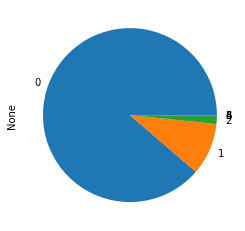

In [ ]:
FinalDF.groupby(['DaysInHospital']).size().plot.pie()

In [ ]:
FinalDF.to_csv(path+'Prediction.csv',index=False) # storing in a CSV file